### 1. Hyperplanes

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import spatial

In [2]:
points = np.asarray([[1, 20], [13, 10], [12, 11]])
points

array([[ 1, 20],
       [13, 10],
       [12, 11]])

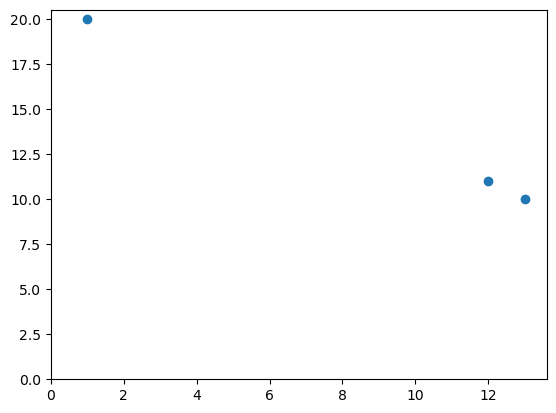

In [3]:
plt.scatter(points[:, 0], points[:, 1])
plt.xlim(0)
plt.ylim(0)
plt.show()

In [4]:
def hash_vec(dim):
    return np.random.rand((dim)) - 0.5

In [5]:
h_vec = hash_vec(2)
h_vec

array([ 0.08121599, -0.4441495 ])

In [6]:
def direction(vec, hash_vec):
    if np.dot(vec, hash_vec) > 0:
        return 1
    else:
        return 0

In [7]:
for xy in points:
    print(direction(xy, h_vec))

0
0
0


In [8]:
nbits = 8 
hash_vecs = []

for n in range(nbits):
    hash_vecs.append(hash_vec(2))
    
hash_vecs = np.stack(hash_vecs)
hash_vecs

array([[ 0.04288076, -0.48426428],
       [-0.44981262, -0.11130619],
       [-0.33387373, -0.46710088],
       [ 0.14399704,  0.17755453],
       [-0.35642902, -0.39135772],
       [ 0.44548185, -0.26267017],
       [ 0.48847201, -0.46117863],
       [ 0.06134313, -0.34436136]])

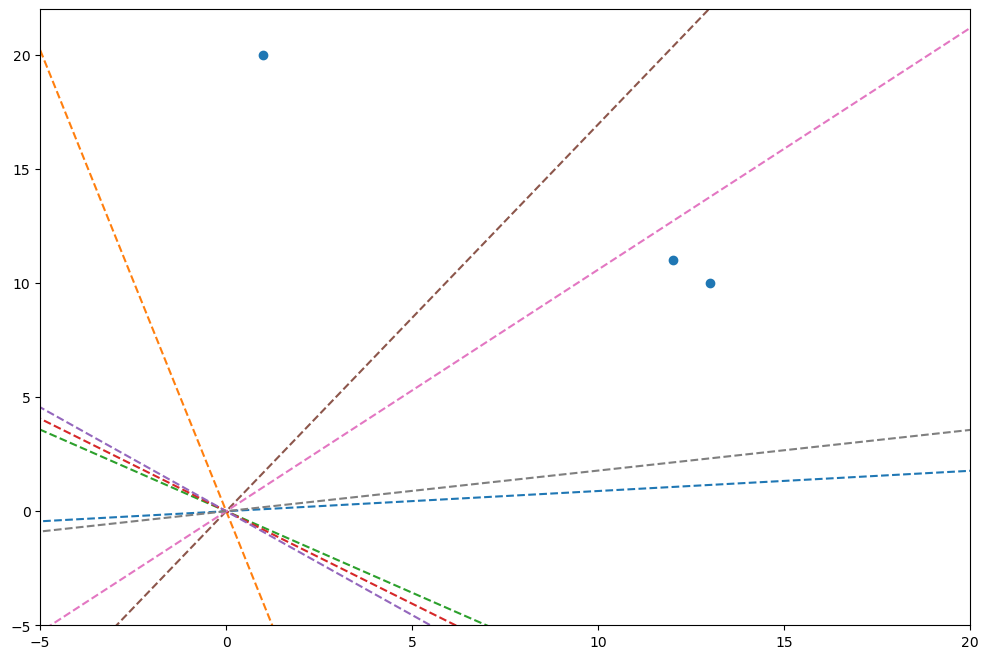

In [9]:
def turn90(vec):
    return -vec[1], vec[0] 

plt.figure(figsize=(12, 8))

for norm in hash_vecs:
    hyperplane = turn90(norm)
    hyperplane = [hyperplane[0] * -1000, hyperplane[0] * 1000], [hyperplane[1] * -1000, hyperplane[1] * 1000]
    plt.plot(hyperplane[0], hyperplane[1], '--')

plt.scatter(points[:, 0], points[:, 1])
plt.xlim(-5, 20)
plt.ylim(-5, 22)
plt.show()

In [10]:
points = points - points.mean(axis=0)

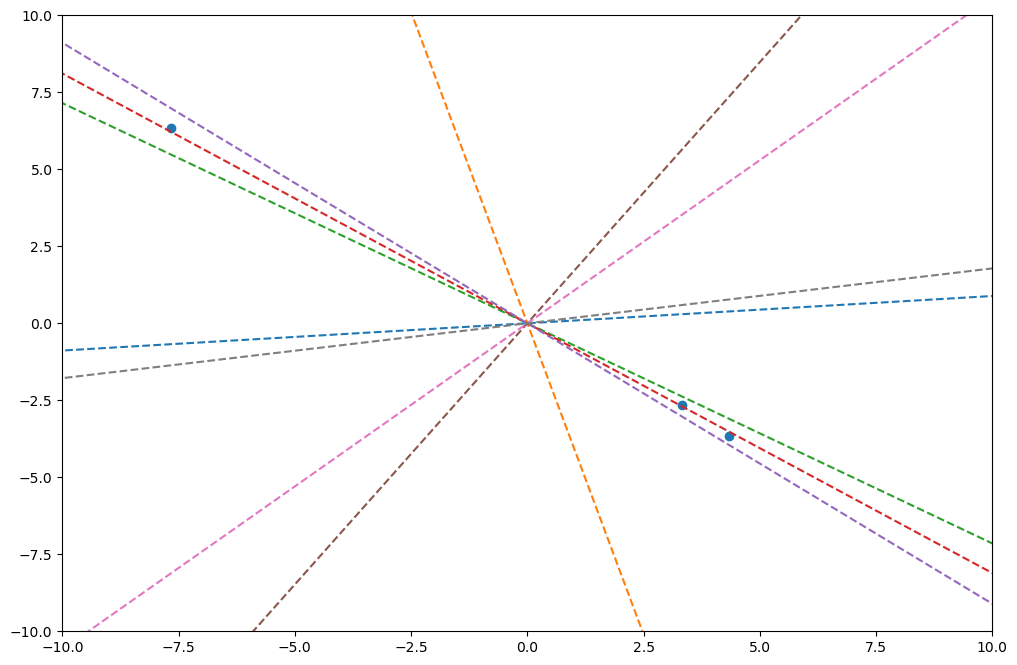

In [11]:
plt.figure(figsize=(12, 8))

for norm in hash_vecs:
    hyperplane = turn90(norm)
    hyperplane = [hyperplane[0] * -1000, hyperplane[0] * 1000], [hyperplane[1] * -1000, hyperplane[1] * 1000]
    plt.plot(hyperplane[0], hyperplane[1], '--')

plt.scatter(points[:, 0], points[:, 1])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

In [12]:
for xy in points:
    binary_hash = ''
    for h_vec in hash_vecs:
        binary_hash += str(direction(xy, h_vec))
    print(binary_hash)

01011000
10100111
10110111


### 2. Random Projection

In [13]:
import numpy as np 
import pandas as pd 
from sklearn.metrics.pairwise import cosine_similarity 
from tqdm import tqdm

In [14]:
def read_fvecs(fp):
    a = np.fromfile(fp, dtype='int32')
    d = a[0] 
    return a.reshape(-1, d + 1)[:, 1:].copy().view('float32')

wb = read_fvecs('sift/sift_base.fvecs')
xq = read_fvecs('sift/sift_query.fvecs')

In [15]:
def all_binary(n):
    total = 1 << n 
    print(f'{total} possible combinations')
    combinations = [] 
    for i in range(total):
        b = bin(i)[2:]
        b = '0' * (n - len(b)) + b 
        b = [int(i) for i in b]
        combinations.append(b)
    return combinations 

In [16]:
class RandomProjection:
    buckets = {} 
    counter = 0 
    def __init__(self, nbits, d):
        self.nbits = nbits 
        self.d = d 
        self.plane_norms = np.random.rand(d, nbits) - 0.5 
        print(f'Initialized {self.plane_norms.shape[1]} hyperplane normal vectors.')
        self.hashes = all_binary(nbits)
        for hash_code in self.hashes:
            hash_code = ''.join([str(i) for i in hash_code])
            self.buckets[hash_code] = []
        self.hashes = np.stack(self.hashes)

    def get_binary(self, vec):
        direction = np.dot(vec, self.plane_norms)
        direction = direction > 0
        binary_hash = direction.astype(int)
        return binary_hash 
    
    def hash_vec(self, vec, show=False):
        binary_hash = self.get_binary(vec)
        binary_hash = ''.join(binary_hash.astype(str))
        self.buckets[binary_hash].append(self.counter)
        if show:
            print(f"{self.counter}: {''.join(binary_hash)}")
        self.counter += 1

    def hamming(self, hashed_vec):
        hamming_dist = np.count_nonzero(hashed_vec != self.hashes, axis=1).reshape(-1, 1)
        hamming_dist = np.concatenate((self.hashes, hamming_dist), axis=1)
        hamming_dist = hamming_dist[hamming_dist[:, -1].argsort()]
        return hamming_dist 
    
    def top_k(self, vec, k=5):
        binary_hash = self.get_binary(vec)
        hamming_dist = self.hamming(binary_hash)
        vec_ids = []
        for row in hamming_dist:
            str_hash = ''.join(row[:-1].astype(str))
            bucket_ids = self.buckets[str_hash]
            vec_ids.extend(bucket_ids)
            if len(vec_ids) >= k:
                vec_ids = vec_ids[:k]
                break
        return vec_ids

In [17]:
projection = RandomProjection(4, wb.shape[1])

Initialized 4 hyperplane normal vectors.
16 possible combinations


In [18]:
projection.plane_norms.shape 

(128, 4)

In [19]:
projection.hashes

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1]])

In [20]:
projection.hash_vec(wb[0], show=True)

0: 1101


In [21]:
projection.buckets

{'0000': [],
 '0001': [],
 '0010': [],
 '0011': [],
 '0100': [],
 '0101': [],
 '0110': [],
 '0111': [],
 '1000': [],
 '1001': [],
 '1010': [],
 '1011': [],
 '1100': [],
 '1101': [0],
 '1110': [],
 '1111': []}

In [22]:
for i in tqdm(range(1, len(wb))):
    projection.hash_vec(wb[i])

100%|██████████| 999999/999999 [00:14<00:00, 69064.22it/s]


In [23]:
projection.buckets

{'0000': [198,
  297,
  325,
  392,
  958,
  1040,
  1458,
  1572,
  1740,
  1894,
  1960,
  2192,
  2380,
  2382,
  2418,
  2540,
  3176,
  3471,
  3772,
  3880,
  3885,
  4063,
  4075,
  4202,
  4238,
  4571,
  4632,
  4670,
  4721,
  4836,
  4965,
  5109,
  5381,
  5452,
  5662,
  5850,
  5932,
  6153,
  6268,
  6539,
  6989,
  7180,
  7605,
  7626,
  7747,
  7777,
  7858,
  7875,
  8083,
  8344,
  8384,
  8420,
  8427,
  8512,
  8513,
  8559,
  8685,
  8701,
  8775,
  8937,
  8978,
  8987,
  9038,
  9091,
  9187,
  9290,
  9372,
  9380,
  9420,
  9432,
  9619,
  10348,
  10418,
  10479,
  10739,
  10846,
  10920,
  10965,
  11136,
  11143,
  11215,
  11665,
  12296,
  13771,
  14050,
  16045,
  16147,
  16185,
  16797,
  16804,
  16939,
  17018,
  17217,
  17481,
  17597,
  17623,
  17773,
  17956,
  17968,
  18178,
  18704,
  18847,
  18856,
  19275,
  19732,
  19785,
  19994,
  20418,
  20552,
  20573,
  20796,
  21161,
  21168,
  21518,
  21612,
  21898,
  22106,
  22114,
  2216

In [24]:
for code in projection.hashes:
    code_str = ''.join(code.astype(str))
    print(f'{code_str}: {len(projection.buckets[code_str])}')

0000: 9341
0001: 10708
0010: 14037
0011: 9674
0100: 11331
0101: 4711
0110: 56265
0111: 10470
1000: 136321
1001: 206615
1010: 74401
1011: 84394
1100: 92595
1101: 118630
1110: 91754
1111: 68753


In [25]:
top_10 = projection.top_k(xq[0], k=10)
top_10

[102, 408, 816, 819, 826, 870, 1348, 1456, 1669, 1708]

In [26]:
cos = cosine_similarity(wb[top_10], [xq[0]])
np.mean(cos)

0.6251164

In [27]:
cos = cosine_similarity(wb, [xq[0]])
np.mean(cos)

0.4223302

In [28]:
def sim_check(query_vecs):
    results = {
        'xq': [],
        'wb': []
    }
    for xq in query_vecs:
        top_10 = projection.top_k(xq, k=10)
        cos = cosine_similarity(wb[top_10], [xq])
        cos = np.mean(cos)
        results['xq'].append(cos)
        cos = cosine_similarity(wb, [xq])
        cos = np.mean(cos)
        results['wb'].append(cos)
    print(f"xq: {np.mean(results['xq'])}")
    print(f"wb: {np.mean(results['wb'])}")
    return results

In [29]:
results = sim_check(xq[:50])

xq: 0.5907036662101746
wb: 0.43162330985069275


In [30]:
''.join(projection.hashes[-5:][0].astype(str))

'1011'

In [31]:
d = wb.shape[0] 
projection = RandomProjection(8, wb.shape[1])

for i in tqdm(range(len(wb))):
    projection.hash_vec(wb[i])

for code in projection.hashes[:5]:
    str_code = ''.join(code.astype(str))
    print(f'{str_code}: {len(projection.buckets[str_code])}')

Initialized 8 hyperplane normal vectors.
256 possible combinations


100%|██████████| 1000000/1000000 [00:16<00:00, 58941.47it/s]

00000000: 734
00000001: 10266
00000010: 494
00000011: 9212
00000100: 27


In [32]:
results = sim_check(xq[:50])

xq: 0.6536803245544434
wb: 0.43162330985069275


In [33]:
import warnings 
warnings.filterwarnings('ignore')

testing = pd.DataFrame({
    'nbits': [],
    'xq_sim': []
})

num_vecs = 50 

for epoch in range(3):
    print('---------------------------------------')
    for nbits in [2, 4, 6, 8, 10, 12]:
        projection = RandomProjection(nbits, wb.shape[1])
        for i in range(len(wb)):
            projection.hash_vec(wb[i])
        results = sim_check(xq[:num_vecs])
        testing = testing.append(
            pd.DataFrame({
                'nbits': [nbits] * num_vecs,
                'xq_sim': results['xq']
            }), ignore_index=True
        )

---------------------------------------
Initialized 2 hyperplane normal vectors.
4 possible combinations
xq: 0.4976266622543335
wb: 0.43162330985069275
Initialized 4 hyperplane normal vectors.
16 possible combinations
xq: 0.5807198882102966
wb: 0.43162330985069275
Initialized 6 hyperplane normal vectors.
64 possible combinations
xq: 0.6241113543510437
wb: 0.43162330985069275
Initialized 8 hyperplane normal vectors.
256 possible combinations
xq: 0.6676082015037537
wb: 0.43162330985069275
Initialized 10 hyperplane normal vectors.
1024 possible combinations
xq: 0.6832010746002197
wb: 0.43162330985069275
Initialized 12 hyperplane normal vectors.
4096 possible combinations
xq: 0.6344621181488037
wb: 0.43162330985069275
---------------------------------------
Initialized 2 hyperplane normal vectors.
4 possible combinations
xq: 0.6020729541778564
wb: 0.43162330985069275
Initialized 4 hyperplane normal vectors.
16 possible combinations
xq: 0.5741927623748779
wb: 0.43162330985069275
Initialized

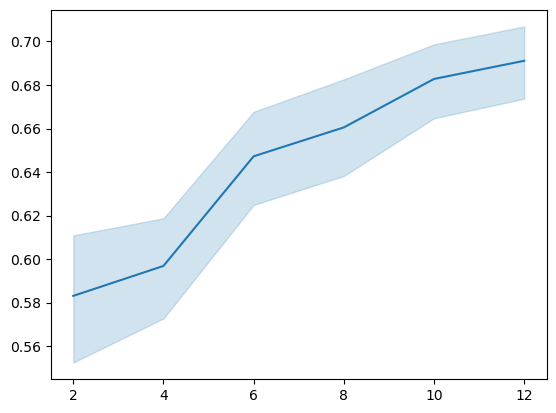

In [34]:
import seaborn as sns 

sns.lineplot(x=testing['nbits'].tolist(), y=testing['xq_sim'].tolist())
plt.show() 

### 3. FAISS Implementation

In [35]:
import numpy as np 
import pandas as pd 
from sklearn.metrics.pairwise import cosine_similarity

In [36]:
def read_fvecs(fp):
    a = np.fromfile(fp, dtype='int32')
    d = a[0] 
    return a.reshape(-1, d + 1)[:, 1:].copy().view('float32')

wb = read_fvecs('sift/sift_base.fvecs')
xq = read_fvecs('sift/sift_query.fvecs')

In [37]:
wb.shape 

(1000000, 128)

In [38]:
import faiss 

d = wb.shape[1] 
nbits = 4 

index = faiss.IndexLSH(d, nbits)
index.add(wb)

In [39]:
xq0 = xq[0].reshape(1, d)
D, I = index.search(xq0, k=10)
I[0]

array([ 0,  2,  6, 25, 26, 43, 47, 70, 73, 74], dtype=int64)

In [40]:
wb[I[0]]

array([[ 0., 16., 35., ..., 25., 23.,  1.],
       [ 0.,  1.,  5., ...,  4., 23., 10.],
       [ 0., 42., 55., ..., 45., 11.,  2.],
       ...,
       [ 5., 12., 31., ...,  2.,  9.,  8.],
       [35., 14., 15., ..., 10., 16., 32.],
       [ 6., 15.,  9., ..., 12., 17., 21.]], dtype=float32)

In [41]:
cosine_similarity(wb[I[0]], [xq[0]])

array([[0.2670474 ],
       [0.20448917],
       [0.3054034 ],
       [0.6914262 ],
       [0.7344476 ],
       [0.6995599 ],
       [0.63165134],
       [0.25432232],
       [0.3049795 ],
       [0.341374  ]], dtype=float32)

In [42]:
k = 100 
xq0 = xq[0].reshape(1, d)

while True:
    D, I = index.search(xq0, k=k)
    if D.any() != 0:
        print(k)
        break 
    k += 100

172100


In [43]:
D

array([[0., 0., 0., ..., 1., 1., 1.]], dtype=float32)

In [44]:
D[:, 172039:172041]

array([[0., 1.]], dtype=float32)

In [45]:
for nbits in [2, 4, 8, 16, 24, 32]:
    buckets = 1 << nbits 
    print(f'nbits == {nbits}')
    print(f'{wb.shape[0]} / {buckets} = {wb.shape[0] / buckets}')

nbits == 2
1000000 / 4 = 250000.0
nbits == 4
1000000 / 16 = 62500.0
nbits == 8
1000000 / 256 = 3906.25
nbits == 16
1000000 / 65536 = 15.2587890625
nbits == 24
1000000 / 16777216 = 0.059604644775390625
nbits == 32
1000000 / 4294967296 = 0.00023283064365386963


In [46]:
xq0 = xq[0].reshape(1, d)
k = 100 

for nbits in [2, 4, 8, 16, 24, 32]:
    index = faiss.IndexLSH(d, nbits)
    index.add(wb)
    D, I = index.search(xq0, k=k)
    cos = cosine_similarity(wb[I[0]], xq0)
    print(np.mean(cos))

0.5424448
0.56082696
0.6372648
0.6676912
0.7132521
0.7051426


In [47]:
xq0 = xq[0].reshape(1, d)
k = 100

results = pd.DataFrame({
    'nbits': [],
    'cos_sim': []
})

for epoch in tqdm(range(20)):
    for nbits in [2, 4, 8, 16, 24, 32, 64, 128]:
        index = faiss.IndexLSH(d, nbits)
        index.add(wb)
        D, I = index.search(xq0, k=k)
        cos = cosine_similarity(wb[I[0]], xq0)
        df = pd.DataFrame({
            'cos_sim': cos.reshape(cos.shape[0])
        })
        df['nbits'] = nbits
        results = results.append(df, ignore_index=True)

100%|██████████| 20/20 [00:48<00:00,  2.44s/it]


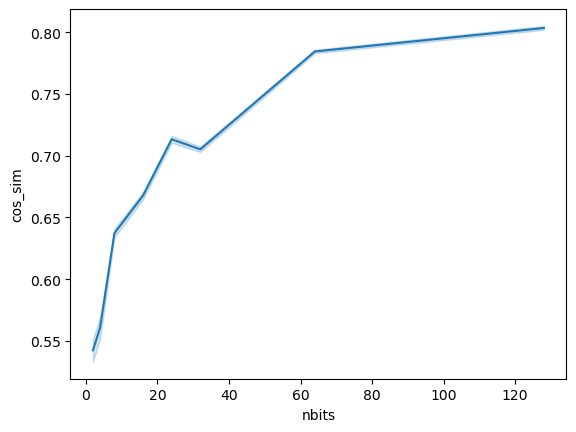

In [48]:
sns.lineplot(data=results, x='nbits', y='cos_sim')
plt.show()

In [49]:
nbits = 4 
index = faiss.IndexLSH(d, nbits)
index.add(wb)

In [50]:
arr = faiss.vector_to_array(index.codes)
arr 

array([ 5, 12,  5, ..., 15, 13, 12], dtype=uint8)

In [51]:
arr.shape

(1000000,)

In [52]:
bin_vecs = (((arr[:, None] & (1 << np.arange(nbits)))) > 0).astype(int)
bin_vecs

array([[1, 0, 1, 0],
       [0, 0, 1, 1],
       [1, 0, 1, 0],
       ...,
       [1, 1, 1, 1],
       [1, 0, 1, 1],
       [0, 0, 1, 1]])

In [53]:
dist_arr = np.apply_along_axis(lambda x: ''.join(x), 1, bin_vecs.astype(str))
dist_arr = pd.DataFrame(dist_arr, columns=['Binary_hash'])
dist_arr

,Binary_hash
0,1010
1,0011
2,1010
3,0011
4,0011
...,...
999995,0011
999996,1011
999997,1111
999998,1011


In [54]:
order_bins = ['0' * (6 - len(bin(x))) + bin(x)[2:] for x in range(16)]
order_bins

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

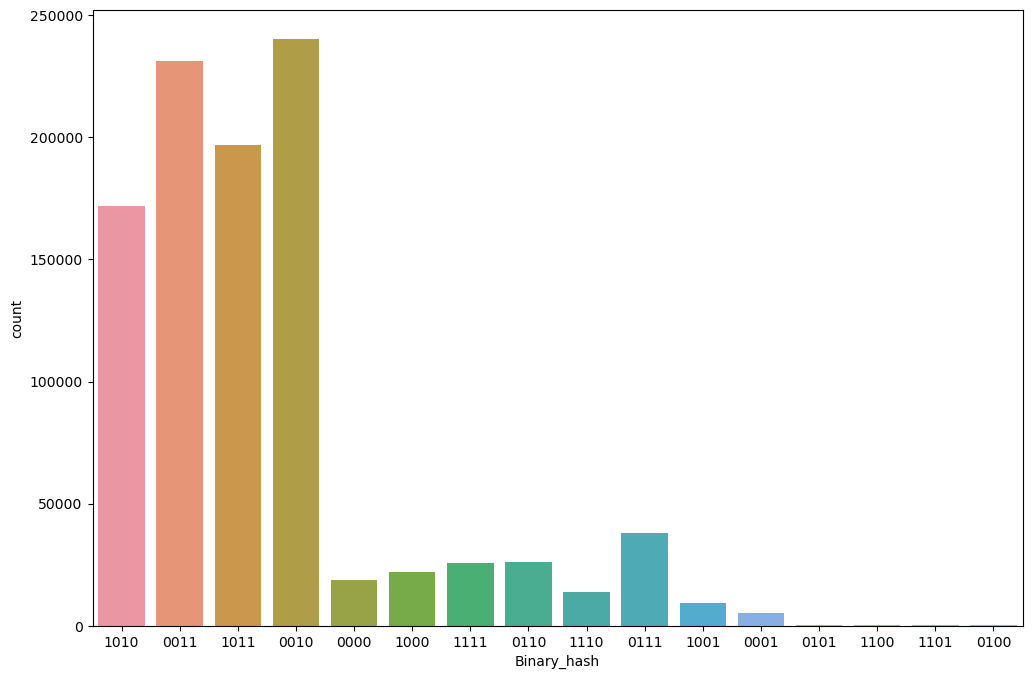

In [55]:
plt.figure(figsize=(12, 8))
sns.countplot(x=dist_arr['Binary_hash'])
plt.xticks(rotation=360)
plt.show() 

In [56]:
from datetime import datetime

k = 50

results = pd.DataFrame({
    'search_time': [],
    'recall': [],
    'nbits': [],
    'nb': []
})

for epoch in tqdm(range(5)):
    for nb in [50_000, 100_000, 250_000, 500_000, 750_000, 1_000_000]:
        index = faiss.IndexFlatL2(d)
        index.add(wb[:nb])
        start = datetime.now()
        D, I = index.search(xq0, k)
        flat_time = (datetime.now() - start).microseconds
        target_ids = I[0].tolist()
        for nbits in [32, 64, 128, 256, 512, 768]:
            index = faiss.IndexLSH(d, nbits)
            index.add(wb[:nb])
            start = datetime.now()
            D, I = index.search(xq0, k)
            lsh_time = (datetime.now() - start).microseconds
            matches = [x for x in I[0].tolist() if x in target_ids]
            recall = len(matches) / k
            results = results.append(
                pd.DataFrame({
                    'search_time': [lsh_time / flat_time],
                    'recall': [recall],
                    'nbits': [nbits],
                    'nb': [nb]
                }), ignore_index=True
            )

100%|██████████| 5/5 [01:51<00:00, 22.30s/it]


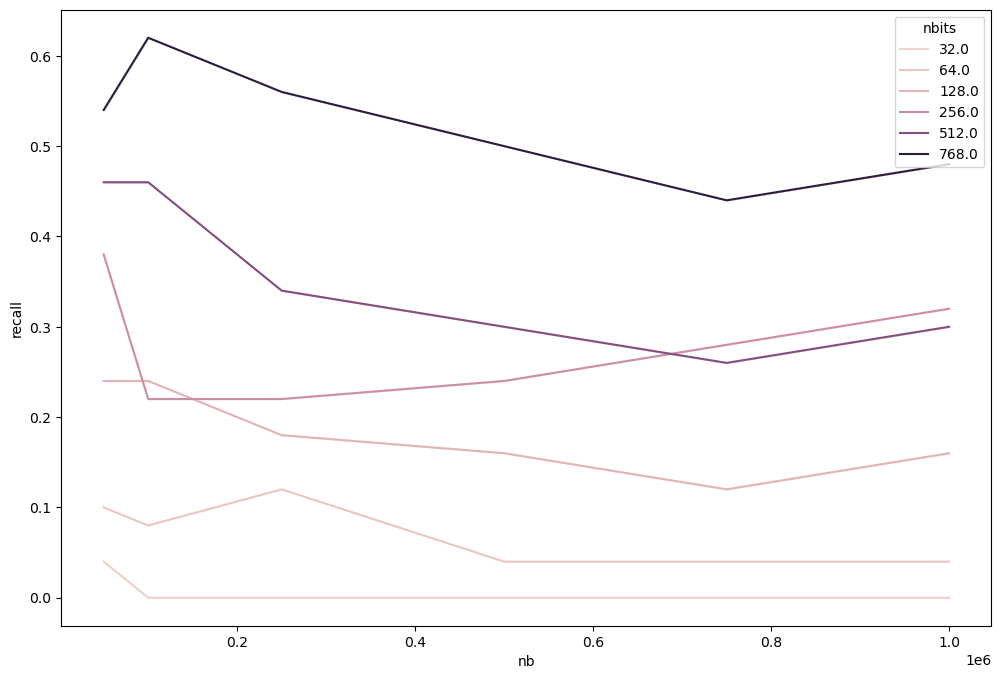

In [57]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=results, x='nb', y='recall', hue='nbits')
plt.show() 

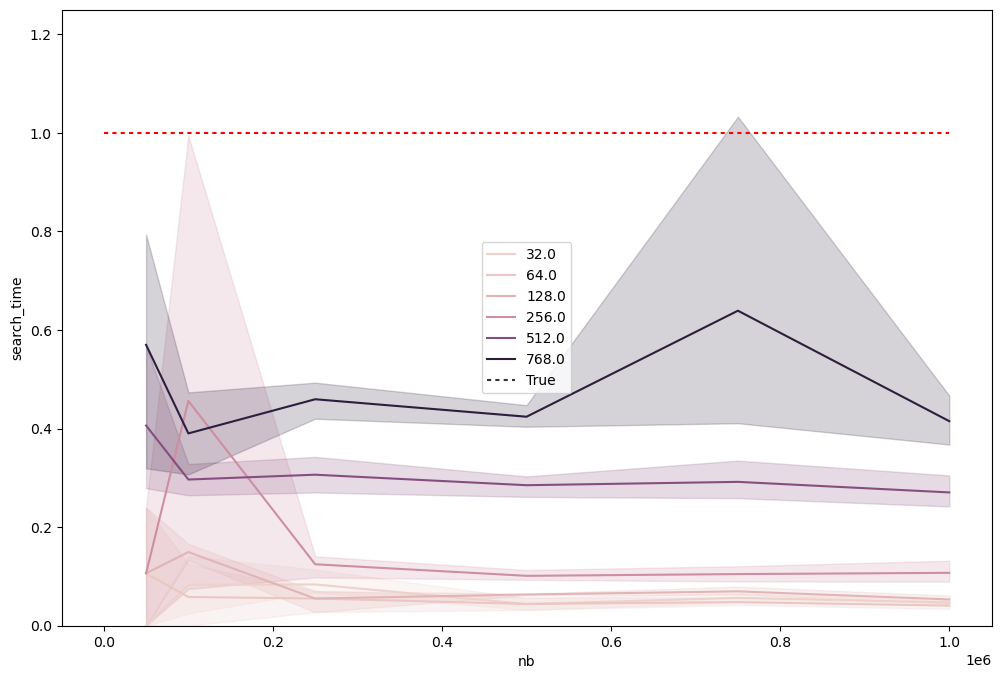

In [62]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=results, x='nb', y='search_time', hue='nbits')
sns.lineplot(x=[0, 1_000_000], y=[1, 1], style=True, dashes=[(2, 2)], color='r')
plt.ylim(0, 1.25)
# plt.tight_layout()
plt.show() 